<h1> A geospatial analysis of the spread of Covid-19 in Bangladesh </h1>
    
This notebook aims to explore the district wise spread of Covid-19 in Bangladesh through mapping data visualisations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd 
import difflib 
import math 
from pathlib import Path

In [2]:
district_geodata = gpd.read_file("../data/bgd_admbnda_adm2_bbs_20180410.shp")

In [3]:
district_geodata['ADM2_EN'].replace({'Chitagong': 'Chattogram'}, inplace=True)

In [4]:
districtwise_data = Path.cwd().parent.joinpath('data', 'district-wise', 'DistrictWise_Distribution_Latest.csv')

In [5]:
cv19_dist = pd.read_csv(districtwise_data, header=1)

In [6]:
cv19_dist.head()

,0,1.0,Unnamed: 2,District/City,Total Cases in District,Total,Updated Date,Unnamed: 7,07 July 2020,08 July 2020,...,22 August 2020,23 August 2020,24 August 2020,25 August 2020,26 August 2020,27 August 2020,28 August 2020,29 August 2020,30 August 2020,31 August 2020
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2.0,Dhaka,Dhaka City,68689.0,105200.0,12.08.2020,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3.0,Dhaka,Dhaka (District),4148.0,105200.0,05.07.2020,NaN,3391.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4.0,Dhaka,Gazipur,4461.0,105200.0,13.08.2020,NaN,3713.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5.0,Dhaka,Kishoreganj,2187.0,105200.0,07.08.2020,NaN,1677.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cv19_dist = cv19_dist.iloc[1:-1]

In [8]:
cv19_dist.rename(columns={'Unnamed: 2': 'Division', 'Total': 'Divisional Cases'}, inplace=True)

In [9]:
cv19_dist.drop(columns=['0', '1.0', 'Unnamed: 7'], inplace=True)

In [10]:
cv19_dist['District/City'].replace({'Dhaka City': 'Dhaka', 'Dhaka (District)': 'Dhaka'}, inplace=True)

In [11]:
temp1 = cv19_dist.groupby(by='District/City', as_index=False).agg(''.join)
temp2 = cv19_dist.groupby(by='District/City', as_index=False).agg(sum)
cv19_dist = temp1.merge(temp2, on='District/City')

In [12]:
#  Corrects for the different english spelling of district names in datasets
cv19_dist['District/City'].replace({'B. Baria': 'Brahamanbaria', 
                                    'Khagrachari': 'Khagrachhari', 
                                    'Chapainawabganj': 'Nawabganj'}, inplace=True)
cv19_dist['Division'].replace({'DhakaDhaka':'Dhaka'}, inplace=True)

In [13]:
def combine_datasets(df1, district_col1, df2, district_col2):
    ''' Combines dataframes on the district name feature.
    This includes a feature to match names which can vary in spelling when translated to English
    '''
    # Corrects for small variations in English spelling of district names between data frames (e.g Comilla and Cumilla) in preparation for joining
    df1[district_col1] = df1[district_col1].apply(
    lambda x: difflib.get_close_matches(x, df2[district_col2], n=1)[0])
    # Combines the data frames of Covid dataset and district coord dataset
    return df1.join(df2.set_index(district_col2), on=district_col1, how = 'outer') 

In [14]:
df_districts_cv19 = combine_datasets(district_geodata, 'ADM2_EN', cv19_dist, 'District/City')

In [15]:
df_districts_cv19 = df_districts_cv19.iloc[:,:19]

In [16]:
df_districts_cv19['Log(Cases)'] = df_districts_cv19['Total Cases in District'].apply(lambda x: math.log10(x) if x > 0 else 1E-2)  

[ 0 26 31  5  1  1]


Text(0.5, 1.0, 'Number of Confirmed Cases by District')

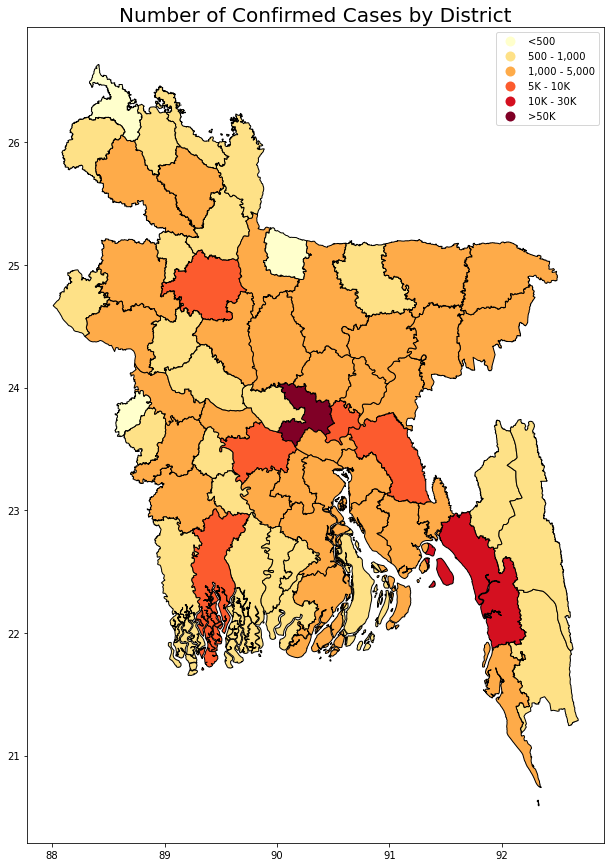

In [17]:
import mapclassify as mc
ud = mc.UserDefined(df_districts_cv19['Log(Cases)'], bins=[2.47,3,3.69,4,4.29,10])
print(ud.counts)                                             
                                               
df_districts_cv19.plot(column='Log(Cases)', figsize=(20,15), zorder=3,
                       edgecolor='k',  
                       cmap='YlOrRd',
                       scheme='UserDefined', 
                       classification_kwds={'bins':[2.69,3, 3.69,4,4.47,10]},
                       legend=True, k=6,
                       legend_kwds={"labels": ['<500', '500 - 1,000', '1,000 - 5,000', 
                                               '5K - 10K', '10K - 30K', '>50K']})
plt.title('Number of Confirmed Cases by District', fontsize=20)

In [18]:
populations_df = pd.read_csv('../data/population_district_wise.csv')

In [19]:
populations_df.head()

,Name,Abbr.,Status,Native,Adm.,Area,Population_1991,Population_2001,Population_2011,Population_2016
0,Barguna,BRG,Dist,?????? ????,BSD,1831,775693,848554,892781,969000
1,Barisal,BRS,Dist,?????? ????,BSD,2785,2207426,2355967,2324310,2583000
2,Bhola,BHO,Dist,???? ????,BSD,3403,1476328,1703117,1776795,1941000
3,Jhalakati,JHA,Dist,??????? ????,BSD,749,666139,694231,682669,741000
4,Patuakhali,PAT,Dist,?????????? ????,BSD,3221,1273872,1460781,1535854,1703000


In [20]:
populations_df.replace({'Chittagong': 'Chattogram'}, inplace=True)

In [21]:
df_districts_cv19_pop = combine_datasets(df_districts_cv19, 'ADM2_EN', populations_df, 'Name')

In [22]:
df_districts_cv19_pop['Confirmed Cases pt'] = 1000*df_districts_cv19_pop['Total Cases in District']/df_districts_cv19_pop['Population_2016']                                    

Text(0.5, 1.0, 'Confirmed Cases Per Thousand People')

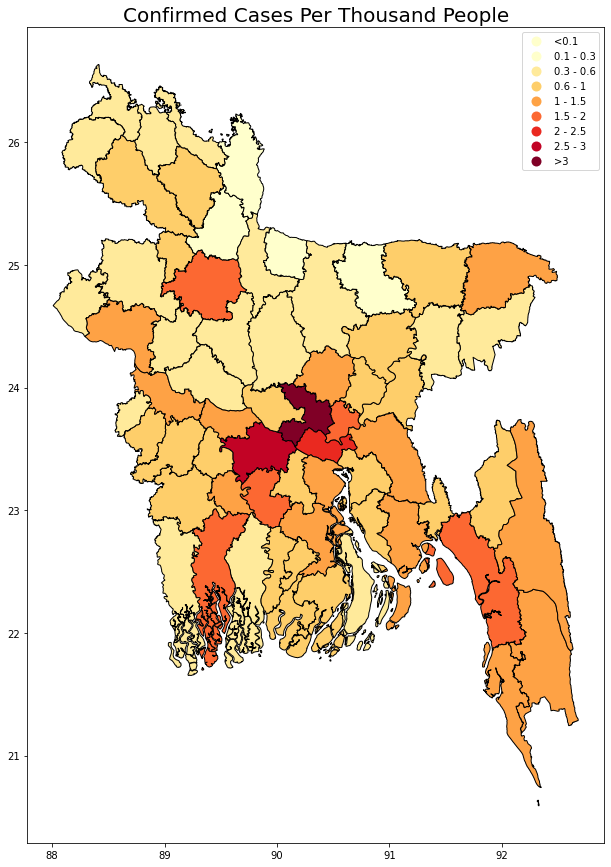

In [23]:
df_districts_cv19_pop.plot(column='Confirmed Cases pt', figsize=(15,15), zorder=3,
                       edgecolor='k',  
                       cmap='YlOrRd',
                       scheme='UserDefined', 
                       classification_kwds={'bins':[0.1,0.3, 0.6,1,1.5,2,2.5,3,10]},
                       legend=True, 
                       legend_kwds={"labels": ['<0.1', '0.1 - 0.3', '0.3 - 0.6', '0.6 - 1',
                                               '1 - 1.5','1.5 - 2', '2 - 2.5', '2.5 - 3', '>3']})
plt.title('Confirmed Cases Per Thousand People', fontsize=20)

In [24]:
df_districts_cv19_pop.columns

Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'ValidTo', 'geometry', 'Division',
       'Updated Date', 'Total Cases in District', 'Divisional Cases',
       'Log(Cases)', 'Abbr.', 'Status', 'Native', 'Adm.', 'Area',
       'Population_1991', 'Population_2001', 'Population_2011',
       'Population_2016', 'Confirmed Cases pt'],
      dtype='object')

In [25]:
df_districts_cv19_pop.rename(columns={'ADM2_EN':'District'}, inplace=True)

In [26]:
cleandatafile = Path.cwd().parent.joinpath('data', 'shapefile', 'data.shp')

In [27]:
df_districts_cv19_pop.to_file(driver='ESRI Shapefile', filename=cleandatafile)

In [28]:
# import plotly.express as px
# from jupyter_dash import JupyterDash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output



# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# # Build App
# app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# colors = {
#     'background': '#fafafa',
#     'text': '#7FDBFF'}

# fig = go.Figure(go.Choroplethmapbox(geojson=df_districts_cv19_pop, 
#                            locations=df_districts_cv19_pop['District'],
#                             z=df_districts_cv19_pop['Log(Cases)'],))
# fig.update_layout(mapbox_style="carto-positron",
#                   mapbox_zoom=6, mapbox_center = {"lat": 23.7 , "lon": 90.3})
# #fig.update_traces(hovertemplate=f"<b>%{locations}</b><br><br>")
# #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


# app.layout = html.Div(
#     style={'backgroundColor': colors['background']}, children=[
#     html.H1("Bangladesh Covid-19 Data",
#             style={
#             'textAlign': 'center',
#             'color': colors['text']}),
#     html.Div(children='An interactive exploration of Covid-19 data for Bangladesh.', style={
#         'textAlign': 'center',
#         'color': colors['text']
#     }),

#     dcc.Graph(id='district-cases', figure=fig)
# ])

# # Run app and display result inline in the notebook
# app.run_server(mode='inline', debug=True)

In [29]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output



external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# Build App
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

colors = {
    'background': '#fafafa',
    'text': '#003366'}

date = '23 July 2020'

fig = px.choropleth_mapbox(df_districts_cv19_pop, geojson=df_districts_cv19_pop, 
                           locations='District', color='Log(Cases)',
                           hover_name='District',
                           hover_data={'Total Cases in District':True, 'Log(Cases)':False, 'District':False} ,
                           center={"lat": 23.7, "lon": 90.2},
                           featureidkey='properties.District',
                           mapbox_style="carto-positron", 
                           zoom=6,
                           opacity=0.7,
                           height=800,
                          title=f'Confirmed Cases Per District.',
                          color_continuous_scale='OrRd',
                          range_color=[1,5])
#fig.update_traces(hovertemplate=f"<b>%{locations}</b><br><br>")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig_density = px.choropleth_mapbox(df_districts_cv19_pop, geojson=df_districts_cv19_pop, 
                           locations='District', color='Confirmed Cases pt',
                           hover_name='District',
                           hover_data={'Confirmed Cases pt':True, 'Total Cases in District':True, 'Population_2016':True, 'Log(Cases)':False, 'District':False} ,
                           center={"lat": 23.7, "lon": 90.2},
                           featureidkey='properties.District',
                           mapbox_style="carto-positron", 
                           zoom=6,
                           opacity=0.7,
                          height=800,
                          title='Confirmed cases per thousdand people per district',
                          color_continuous_scale='OrRd',
                          range_color=[0,4])

fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'])

fig_density.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text'])


table_contents = '''
1. Map of [confirmed cases per district.](#district-cases)
2. Map of [confirmed cases per thousdand people.](#district-cases_pt)
'''

introduction = '''
An interactive exploration of Covid-19 data for Bangladesh.

Data source: [IEDCR](https://iedcr.gov.bd/).
Data on this page last updated: 23 July 2020.
'''

top = '''
[(top)](#top)'''

app.layout = html.Div(
    style={'backgroundColor': colors['background']}, children=[
    html.H1("Bangladesh Covid-19 Data",
            style={
            'textAlign': 'center',
            'color': colors['text']}),
    html.Div([dcc.Markdown(children=introduction)], 
             style={
        'textAlign': 'center',
        #'font_size': '20vw',
        'color': colors['text']
    }),
    html.Div(children=[dcc.Markdown(children=table_contents)], id='top', style={
        'textAlign': 'left',
        'color': colors['text']
    }),
    
        
    dcc.Graph(id='district-cases', figure=fig, style={'width':'90vw'}),
    html.Div([dcc.Markdown(children=top)]),
        
    dcc.Graph(id='district-cases_pt', figure=fig_density, style={'width':'90vw'}),
    html.Div([dcc.Markdown(children=top)]),       
])

# Run app and display result inline in the notebook
app.run_server(mode='external', debug=True)

Dash app running on http://127.0.0.1:8050/


In [30]:
from geopandas.tools import geocode

In [31]:
result = geocode(districts, provider='nominatim', user_agent="TGreen")
result

NameError: name 'districts' is not defined

In [ ]:
#Create map of district and divisional case numbers which will include clorepleth and markers layered for each 

m = folium.Map(
    location=[np.median(df_districts_cv19['lat']),np.median(df_districts_cv19['lon'])],
    zoom_start=7, 
)

layer1=folium.FeatureGroup(name='District Markers', show=False)
layer2=folium.FeatureGroup(name='Division Markers', show=False)

m.add_child(layer1)
m.add_child(layer2)

for index,rows in df_districts_cv19.iterrows():
    if rows['lat'] and rows['lon']:
        folium.Marker([rows['lat'], rows['lon']], popup='District: '+(str(rows['name']))+'\n\nConfirmed cases: '+str(rows['TOTAL']), 
                      icon=folium.Icon(color='orange', icon='info-sign')                     
                     ).add_to(layer1)

for index,rows in df_divisions.iterrows():
    if rows['lat'] and rows['lon']:
        folium.Marker([rows['lat'], rows['lon']], popup='Division: '+(str(rows['geoname']))+'\n\nConfirmed cases: '+str(rows['TOTAL']), 
                      icon=folium.Icon(color='darkpurple', icon='info-sign')                     
                     ).add_to(layer2)
        
folium.Choropleth(
    geo_data = district_geodata,
    name='District Chloropleth',
    data=df_districts_cv19,
    columns=['geoname', 'logtotal'],
    key_on='feature.properties.ADM2_EN',
    legend_name='Confirmed Cases of Covid-19 [log]',
    fill_color='Oranges',
    highlight = True, 
    #bins = [0.0001, math.log10(10),math.log10(25),math.log10(50),math.log10(100),math.log10(200),math.log10(400),math.log10(1000),math.log10(10000),math.log10(50000)]    
).add_to(m)

folium.Choropleth(
    geo_data = division_geodata,
    name='Division Chloropleth',
    data=df_divisions,
    columns=['geoname', 'logtotal'],
    key_on='feature.properties.ADM1_EN',
    legend_name='Confirmed Cases of Covid-19 [log]',
    fill_color='Purples',
    highlight = True, 
    #bins = [0.0001, math.log10(10),math.log10(25),math.log10(50),math.log10(100),math.log10(200),math.log10(500),math.log10(1000),math.log10(5000),math.log10(10000),math.log10(15000)]    
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

m.save('Covid19_GeographicDistribution_BD.html')
m